In [163]:
from collections import Counter

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from collections import OrderedDict 
from sklearn.decomposition import PCA
from matplotlib import pyplot
from random import randint


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_validate

movie_df = pd.read_csv(r'data/data_regression.csv')
movie_df = movie_df.set_index('imdb_id')

In [164]:
movie_df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,Hugh Jackman,...,0,1,0,0,0,0,0,6,3,4
tt0080339,Jim Abrahams,134.0,88.0,104.0,318.0,Lloyd Bridges,628.0,83400000.0,Comedy,Peter Graves,...,0,0,0,0,0,0,1,2,3,4
tt0080453,Randal Kleiser,36.0,104.0,116.0,83.0,Christopher Atkins,1000.0,58853106.0,Adventure|Drama|Romance,Brooke Shields,...,0,0,0,1,0,0,0,3,3,3
tt0080455,John Landis,125.0,148.0,644.0,326.0,Aretha Franklin,1000.0,54200000.0,Action|Comedy|Crime|Music,John Belushi,...,0,0,0,1,0,1,0,3,3,4
tt0080487,Harold Ramis,71.0,98.0,11000.0,484.0,Rodney Dangerfield,13000.0,39800000.0,Comedy|Sport,Bill Murray,...,0,0,0,0,0,1,0,7,3,5


In [198]:
words_df = movie_df[['plot_keywords','budget', 'gross']]
words = words_df.plot_keywords
words = [x.split("|") for x in words]


for i in range(len(words_df.plot_keywords)):
    words[i] = [x.split() for x in words[i]]
    w = []
    
    # delete sub list
    for j in range(len(words[i])):
        for k in range(len(words[i][j])):
            if len(words[i][j][k])>2 and ' ' not in words[i][j][k]:
                w.append(words[i][j][k])
    
    words[i] = w
    
    # delete duplicates
    words[i] = list(OrderedDict.fromkeys(words[i])) 

In [199]:
words_df.plot_keywords = words
words_df.head()

,plot_keywords,budget,gross
imdb_id,,,
tt0035423,"[bridge, brooklyn, falling, down, elevator, sh...",48000000.0,47095453.0
tt0080339,"[air, traffic, controller, airplane, airport, ...",3500000.0,83400000.0
tt0080453,"[coming, age, island, poison, teenage, boy, girl]",4500000.0,58853106.0
tt0080455,"[band, catholic, money, parolee, prison]",27000000.0,54200000.0
tt0080487,"[caddy, country, club, golf, course, gopher, n...",6000000.0,39800000.0


In [200]:
movie_genre_df = pd.read_csv(r'data/data_genre.csv')
movie_genre_df = movie_genre_df.set_index('imdb_id')

words_df = words_df.merge(movie_genre_df, how='left', left_index=True, right_index=True)

In [212]:
genres = [
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War', 'Others']

for genre in genres:
    print(genre)
    
    column = words_df[genre]
    
    words_genre_df = words_df[column==1]
    
    words_genre = []
    num_film_word = [0]*len(words_genre_df)
    
    # delete sub list
    for j in range(len(words_genre_df)):
        for k in range(len(words_genre_df.plot_keywords[j])):
            if len(words_genre_df.plot_keywords[j][k])>2 and ' ' not in words_genre_df.plot_keywords[j][k]:
                words_genre.append(words_genre_df.plot_keywords[j][k])
    
    words_genre = list(dict.fromkeys(words_genre))
    
    budget_word = [0] * len(words_genre)
    gross_word = [0] * len(words_genre)
    num_film_word = [0] * len(words_genre)
    
    #for each word see budget
    for i in range(len(words_genre))[:10]:
        word = words_genre[i]
        budget_word[i] = 0
        gross_word[i] = 0
        
        for j in range(len(words_genre_df)): # all films
            words_movie = words_genre_df.plot_keywords[j]
            if word in words_movie:
                num_film_word[i] = num_film_word[i] + 1
                budget_word[i] = budget_word[i] + words_genre_df.budget[j]
                gross_word[i] = gross_word[i] + words_genre_df.gross[j]
        
        if num_film_word[i] > 2: # no if zero (not find) or an exception (only one/two)
            budget_word[i] = budget_word[i]/num_film_word[i]
            gross_word[i] = gross_word[i]/num_film_word[i]
        else: 
            words_genre[i] = 0

    words_genre = [i for i in words_genre if i != 0]
    word_budget_df = pd.DataFrame([words_genre,budget_word, gross_word, num_film_word])
    word_budget_df = word_budget_df.rename({0:"word", 1:"mean_budget", 2:"mean_gross", 3:"num_film_word"}).T
    word_budget_df = word_budget_df.sort_values('mean_budget', ascending=False) #order by budget
    word_budget_df = word_budget_df.set_index('word')
    print("Order by budget:")
    display(word_budget_df.sort_values('mean_budget', ascending=False)[['mean_budget', 'num_film_word']].head(10)) #order by budget
    print("Order by gross:")
    display(word_budget_df.sort_values('mean_gross', ascending=False)[['mean_gross', 'num_film_word']].head(10)) #order by budget
    print("\n")
    
    

Biography
Order by budget:


,mean_budget,num_film_word
word,,
rear,5.26667e+07,3
music,4.91271e+07,2
nudity,3.94621e+07,13
frontal,2.80012e+07,6
male,2.59552e+07,11
city,2.46045e+07,6
york,2.44378e+07,6
kissing,2.39378e+07,6
full,2.3845e+07,4


Order by gross:


,mean_gross,num_film_word
word,,
music,9.85639e+07,2
kissing,5.53122e+07,6
rear,4.85901e+07,3
nudity,3.50042e+07,13
male,2.51424e+07,11
city,1.12316e+07,6
frontal,1.07198e+07,6
full,8.20665e+06,4
york,5.48889e+06,6




Comedy
Order by budget:


,mean_budget,num_film_word
word,,
travel,9.8e+07,2
time,6.8e+07,2
romance,6.3e+07,2
air,4.77175e+07,20
traffic,4.18565e+07,31
falling,3.33333e+07,6
airplane,2.89e+07,5
bridge,2.3e+07,3
controller,2.175e+07,4


Order by gross:


,mean_gross,num_film_word
word,,
travel,1.08208e+08,2
romance,8.09555e+07,2
air,6.82854e+07,20
controller,6.59532e+07,4
traffic,6.07155e+07,31
time,5.76645e+07,2
airplane,5.55868e+07,5
falling,4.52254e+07,6
brooklyn,3.16047e+07,5




Crime
Order by budget:


,mean_budget,num_film_word
word,,
family,5.5e+07,2
texas,5.22857e+07,7
weapon,4.975e+07,8
martial,3.42967e+07,36
catholic,3.2e+07,2
prison,3.03468e+07,35
arts,2.81103e+07,29
drugs,2.7e+07,1
money,1.96667e+07,3


Order by gross:


,mean_gross,num_film_word
word,,
family,8.265e+07,2
money,6.44303e+07,3
catholic,5.7419e+07,2
drugs,5.42e+07,1
texas,5.40825e+07,7
weapon,5.20612e+07,8
arts,4.70726e+07,29
martial,4.49554e+07,36
prison,3.07359e+07,35




Drama
Order by budget:


,mean_budget,num_film_word
word,,
island,3.88868e+07,19
country,2.81927e+07,10
kissing,2.69378e+07,6
boy,2.61837e+07,55
girl,2.28223e+07,45
music,2.06151e+07,15
coming,1.71997e+07,13
age,1.64338e+07,20
teenage,1.29384e+07,15


Order by gross:


,mean_gross,num_film_word
word,,
kissing,5.17751e+07,6
island,4.15723e+07,19
country,3.82803e+07,10
music,3.40335e+07,15
age,2.50954e+07,20
poison,2.31302e+07,3
coming,2.28032e+07,13
girl,2.25139e+07,45
boy,2.16802e+07,55




Romance
Order by budget:


,mean_budget,num_film_word
word,,
travel,6.3e+07,2
elevator,4.8e+07,1
time,4.26965e+07,3
falling,3.19444e+07,9
bridge,2.975e+07,4
brooklyn,2.93333e+07,3
romance,2.515e+07,9
island,2.3724e+07,5
age,2.07143e+07,7


Order by gross:


,mean_gross,num_film_word
word,,
travel,8.09555e+07,2
falling,5.99306e+07,9
coming,4.90532e+07,11
elevator,4.70955e+07,1
romance,4.54925e+07,9
brooklyn,4.13029e+07,3
age,3.62379e+07,7
island,3.59159e+07,5
bridge,3.27504e+07,4




Mystery_Thriller_Horror
Order by budget:


,mean_budget,num_film_word
word,,
titanic,8.03077e+07,13
psychiatrist,4.73571e+07,7
ship,4.13182e+07,11
murder,3.08574e+07,111
military,1.9e+07,2
elevator,1.79e+07,5
apartment,1.672e+07,10
california,1.05e+07,2
mineral,1e+06,1


Order by gross:


,mean_gross,num_film_word
word,,
ship,4.91643e+07,11
military,4.69706e+07,2
elevator,4.68937e+07,5
titanic,4.68222e+07,13
california,4.49079e+07,2
psychiatrist,3.338e+07,7
murder,3.21444e+07,111
mineral,2.1378e+07,1
ocean,2.1378e+07,1




Sci-Fi_Fantasy
Order by budget:


,mean_budget,num_film_word
word,,
falling,7.3e+07,2
bridge,6.555e+07,4
duel,6.25433e+07,29
elevator,5.9e+07,3
romance,5.71507e+07,45
down,5.62e+07,5
time,5.03974e+07,4
travel,4.8e+07,1
twist,4.6e+07,3


Order by gross:


,mean_gross,num_film_word
word,,
twist,1.47745e+08,3
falling,1.2713e+08,2
romance,6.04287e+07,45
duel,6.03388e+07,29
bridge,5.7081e+07,4
travel,4.70955e+07,1
famous,4.12399e+07,5
down,4.09569e+07,5
time,3.76467e+07,4




Family_Animation
Order by budget:


,mean_budget,num_film_word
word,,
star,1.33021e+08,25
bully,4.525e+07,6
reference,4.05e+07,2
karate,3.99773e+07,11
story,2.175e+07,4
boy,1.05e+07,1
fight,1.05e+07,1
master,1.05e+07,1
book,1.05e+07,1


Order by gross:


,mean_gross,num_film_word
word,,
reference,4.66693e+08,2
boy,4.34949e+08,1
fight,4.34949e+08,1
master,4.34949e+08,1
book,4.34949e+08,1
bully,1.16885e+08,6
karate,9.9186e+07,11
dragon,9.08e+07,1
story,5.7376e+07,4




Action_Adventure
Order by budget:


,mean_budget,num_film_word
word,,
girl,1.15192e+08,32
band,7.33783e+07,23
island,6.14173e+07,26
age,6.075e+07,6
coming,6.0125e+07,4
boy,5.98636e+07,11
money,4.64e+07,5
prison,4.62163e+07,17
parolee,3.835e+07,2


Order by gross:


,mean_gross,num_film_word
word,,
age,1.12071e+08,6
coming,1.01395e+08,4
boy,9.13385e+07,11
island,8.94977e+07,26
teenage,8.6683e+07,2
band,7.14702e+07,23
money,5.89018e+07,5
parolee,5.44293e+07,2
prison,4.92794e+07,17




History_War
Order by budget:


,mean_budget,num_film_word
word,,
breasts,1.29e+08,2
loss,5e+07,2
movie,3.76e+07,5
boat,2.5e+07,3
female,1e+07,1
submarine,1e+07,1
tension,1e+07,1
army,1e+07,1
boot,1e+07,1


Order by gross:


,mean_gross,num_film_word
word,,
loss,1.9487e+08,2
female,6.98e+07,1
submarine,6.98e+07,1
tension,6.98e+07,1
army,6.98e+07,1
boot,6.98e+07,1
camp,6.98e+07,1
boat,6.80072e+07,3
breasts,5.2345e+07,2




Others
Order by budget:


,mean_budget,num_film_word
word,,
caddy,2.7525e+07,12
prison,2.7e+07,1
course,2.6e+07,2
country,2.43333e+07,3
nudity,2.43333e+07,3
band,2.42937e+07,23
gopher,2.40784e+07,8
money,1.70009e+07,5
golf,1.24378e+07,6


Order by gross:


,mean_gross,num_film_word
word,,
course,6.46483e+07,2
prison,5.42e+07,1
caddy,4.78977e+07,12
golf,3.37203e+07,6
gopher,3.13702e+07,8
band,2.85263e+07,23
money,2.66123e+07,5
country,2.53965e+07,3
nudity,2.53965e+07,3


In [138]:
words_df = movie_df[['plot_keywords']]
words = words_df.plot_keywords
words = [x.split("|") for x in words]
words = [" ".join(x) for x in words]

In [69]:
words

['bridge brooklyn falling down elevator shaft time travel romance',
 'air traffic controller airplane airport pilot spoof',
 'coming age island poison teenage boy girl',
 'band catholic money parolee prison',
 'caddy country club golf course gopher nudity',
 'male frontal nudity full rear new york city',
 'country music kissing while having sex poverty singer title based song',
 'apartment elevator murder psychiatrist sunglasses',
 'curiosity exploitation freak hospital physical deformity',
 'duel famous twist rebel rescue snowy landscape',
 'california fog leper lighthouse ship',
 '1890s hired gun immigrant johnson county war sheriff',
 'choir death friend suicide therapy',
 'camera shot feet female stockinged loss husband pantyhose suntan',
 'boxing domestic violence hot temper jealousy rage',
 'military mineral ocean ship titanic',
 'breaking down door haunted hotel identical twins labyrinth twin sisters',
 'alien invasion based comic book flying superhero phantom zone revenge',
 'c

In [70]:
len(words)

3852

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

count_model = TfidfVectorizer(ngram_range=(1,1))
v = count_model.fit_transform(words)

Xc = (v.T * v) # this is co-occurrence matrix in sparse csr format
Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
X = Xc.todense()
print(X.shape)

(5409, 5409)


In [82]:
v.shape

(3852, 5409)

In [83]:
X.shape

(5409, 5409)

In [84]:
# target 
movie_genre_df = pd.read_csv(r'data/data_genre.csv')

target = []

for i in range(len(movie_genre_df)):
    index = movie_genre_df.index[i]
    rowData = movie_genre_df.loc[ index , : ]
    
    if rowData.Drama==1 :
        target.append('Drama')
    elif rowData.Comedy==1 :
        target.append('Comedy')
    elif rowData.Mystery_Thriller_Horror==1 :
        target.append('Mystery_Thriller_Horror')
    elif rowData.Action_Adventure==1 :
        target.append('Action_Adventure')
    elif rowData['Sci-Fi_Fantasy']==1 :
        target.append('Sci-Fi_Fantasy')
    elif rowData.Romance==1 :
        target.append('Romance')
    elif rowData.Crime==1 :
        target.append('Crime')
    elif rowData.Family_Animation==1 :
        target.append('Family_Animation')
    else :
        target.append('Other')
        
# colors 
colors = []

for i in range(9):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

target_no_dup = list(dict.fromkeys(target))
dic_tar_col = dict(zip(target_no_dup,colors))
dic_tar_col

{'Comedy': '#7887B0',
 'Drama': '#6764EB',
 'Mystery_Thriller_Horror': '#9F1EC0',
 'Action_Adventure': '#7882A1',
 'Sci-Fi_Fantasy': '#D6242A',
 'Other': '#EA6CA7',
 'Romance': '#6E86E6',
 'Crime': '#25EA68'}

In [91]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
com1 = principalComponents[:,0]
com2 = principalComponents[:,1]


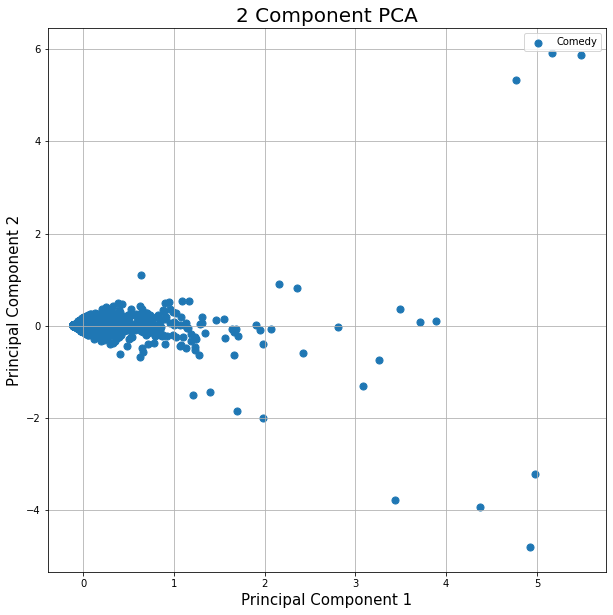

In [92]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

ax.scatter(com1, com2
               , s = 50)
    
ax.legend(list(dic_tar_col.keys()))
ax.grid()

In [79]:
finalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf['Target'] = target
finalDf.head()

,principal component 1,principal component 2,Target
0,-0.023632,-0.015264,Comedy
1,-0.017945,-0.009931,Comedy
2,-0.031129,-0.013079,Drama
3,-0.006957,-0.020605,Comedy
4,0.001599,0.119167,Comedy


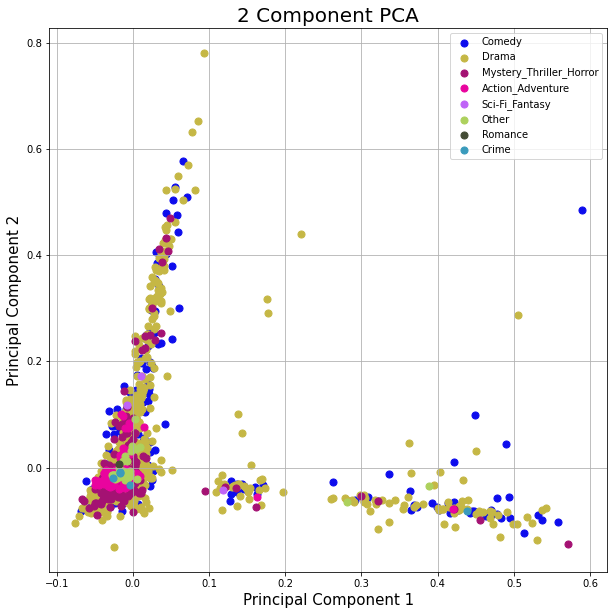

In [80]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

for i in range(len(dic_tar_col)):
    t = list(dic_tar_col.keys())[i]
    cc = dic_tar_col.get(t)
    
    indicesToKeep = finalDf['Target'] == t
    
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = cc
               , s = 50)
    
ax.legend(list(dic_tar_col.keys()))
ax.grid()